In [49]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

plt.style.use('classic')
import scipy.stats as ss
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

from arch import arch_model


## Part A


## i)

Read in data, compute log returns etc. Plot hist, kde & normal fit

In [53]:
df = pd.read_csv("./data/QRM-2022-cw1-data-a.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['log_returns'] = np.log(1 + df['SX5E'].pct_change())


In [3]:
mean = df['log_returns'].mean()
stdev = df['log_returns'].std()
skew = df['log_returns'].skew()
kurt = df['log_returns'].kurtosis()

print(f"Mean: {mean}")
print(f"Stdev: {stdev}")
print(f"Skew: {skew}")
print(f"Kurtosis: {kurt}")

Mean: 0.00015487112907364611
Stdev: 0.012441542517269
Skew: -0.777391523854068
Kurtosis: 10.114398493613315


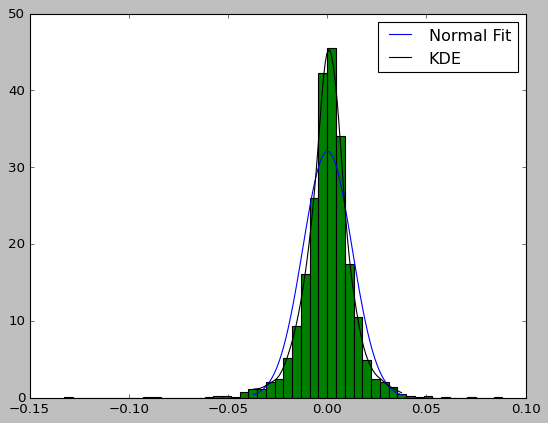

In [6]:

kde = ss.gaussian_kde(df['log_returns'].dropna())
x = np.linspace(mean - 3*stdev, mean + 3*stdev, 100)

plt.plot(x, ss.norm.pdf(x, mean, stdev), label= 'Normal Fit');
plt.hist(df['log_returns'], bins=50, density=True); 
plt.plot(x, kde(x), label='KDE', color='k');

plt.legend(); plt.show()

## A ii)

In [51]:
df['log_returns']

Date
2012-11-05         NaN
2012-11-06    0.007231
2012-11-07   -0.022669
2012-11-08    0.000012
2012-11-09    0.000278
                ...   
2022-10-31    0.001250
2022-11-01    0.009212
2022-11-02   -0.007977
2022-11-03   -0.007992
2022-11-04    0.026136
Name: log_returns, Length: 2510, dtype: float64

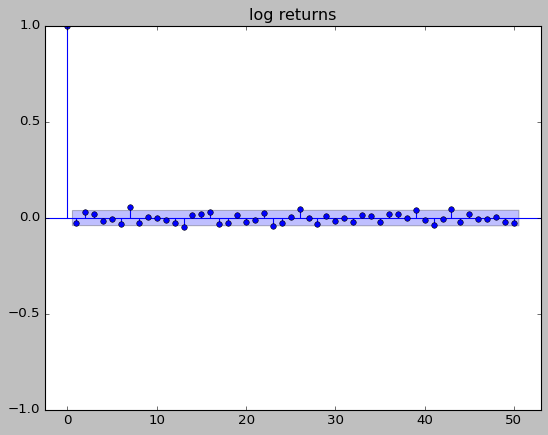

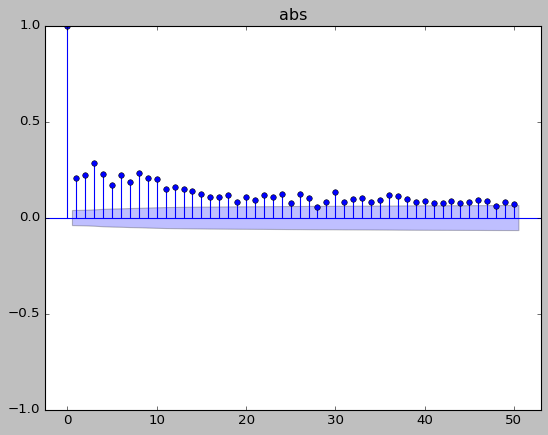

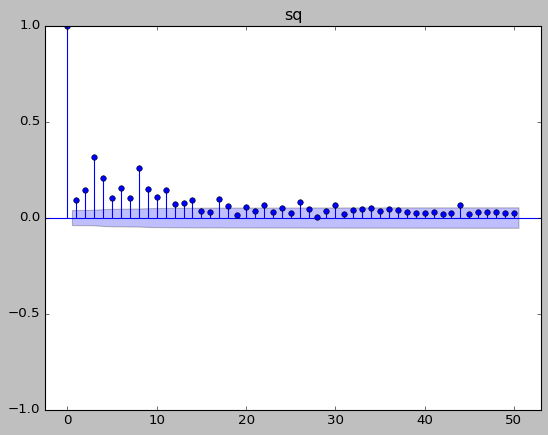

In [21]:


sm.graphics.tsa.plot_acf(df['log_returns'].dropna(), lags=50, title='log returns'); plt.show()
sm.graphics.tsa.plot_acf(np.abs(df['log_returns']).dropna(), lags=50, title='abs'); plt.show()
sm.graphics.tsa.plot_acf(df['log_returns'].dropna()**2, lags=50, title='sq'); plt.show()



# A iii)

In [54]:
df['log_returns'].dropna()

Date
2012-11-06    0.007231
2012-11-07   -0.022669
2012-11-08    0.000012
2012-11-09    0.000278
2012-11-12   -0.002544
                ...   
2022-10-31    0.001250
2022-11-01    0.009212
2022-11-02   -0.007977
2022-11-03   -0.007992
2022-11-04    0.026136
Name: log_returns, Length: 2509, dtype: float64

In [55]:
# make GARCH(1,1) model with normal innovations
model = arch_model(df['log_returns'].dropna(),
                 mean='Constant', 
                 vol='GARCH', 
                 p=1, q=1, rescale=True, dist='normal')

model_fit = model.fit(update_freq=5)
model_fit.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: 3866.417847357737
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3758.8529964213376
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3758.852995610687
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3758.85
Distribution:                  Normal   AIC:                           7525.71
Method:            Maximum Likelihood   BIC:                           7549.02
                                        No. Observations:                 2509
Date:                Tue, Nov 22 2022   Df Residuals:                     2508
Time:                        16:12:26   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0590  2.093e-02      2.819  4.812e-03 [1.799e-02,  0.100]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0543  1.879e-02      2.892  3.831e-03 [1.751e-02,9.118e-02]
alpha[1]       0.1303  3.114e-02      4.184  2.861e-05   [6.927e-02,  0.191]
beta[1]        0.8364  3.552e-02     23.549 1.285e-122     [  0.767,  0.906]
============================================================================

Covariance estimator: robust
"""

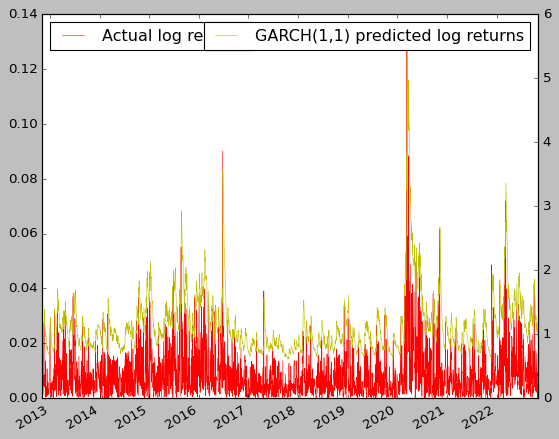

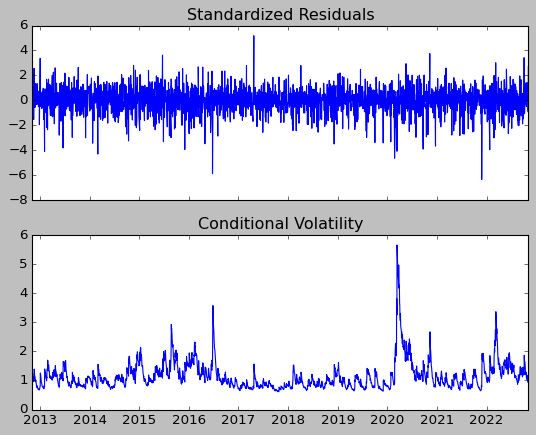

In [56]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(np.abs(df['log_returns'].dropna()), 'r-', linewidth=0.5, label='Actual log returns')
ax2.plot(model_fit.conditional_volatility, 'y-', linewidth=0.5, label='GARCH(1,1) predicted log returns')

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
# ax1.xaxis.set_minor_locator(mdates.MonthLocator()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.legend(loc=0); ax2.legend(loc=1)
model_fit.plot(); plt.show()



## a iv)

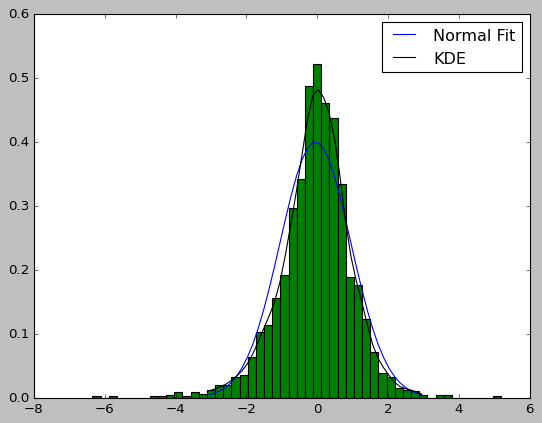

In [66]:
errors_std = np.std(model_fit.std_resid)
errors_mu = np.mean(model_fit.std_resid)

kde = ss.gaussian_kde(model_fit.std_resid)

x = np.linspace(errors_mu - 3*errors_std, errors_mu + 3*errors_std, 40)

plt.plot(x, ss.norm.pdf(x, errors_mu, errors_std), label= 'Normal Fit');

plt.plot(x, kde(x), label='KDE', color='k');
plt.hist(model_fit.std_resid, bins=50, density=True);


plt.legend(); plt.show()

### doesnt look super notmal too me...



## A v)

In [11]:
# poa
# 1. fit arimia model for the mea
# 2. fit garch model to the residuals 1,1 with t dist 



In [25]:
arma_model_fit.resid

Date
2012-11-05         NaN
2012-11-06    0.007076
2012-11-07   -0.022617
2012-11-08   -0.000834
2012-11-09    0.000214
                ...   
2022-10-31    0.001163
2022-11-01    0.009080
2022-11-02   -0.007872
2022-11-03   -0.008418
2022-11-04    0.025782
Length: 2510, dtype: float64

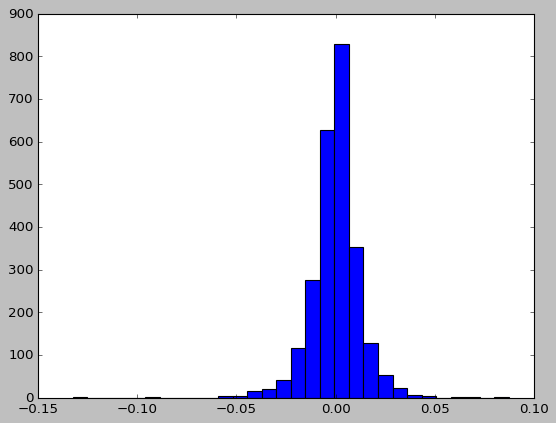

In [41]:
plt.hist(residuals, bins=30); plt.show()

In [65]:
arma_model_fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 2509
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4104.290
Date:                Tue, 22 Nov 2022   AIC                           8216.580
Time:                        16:29:02   BIC                           8239.890
Sample:                             0   HQIC                          8225.041
                               - 2509                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.025      0.601      0.548      -0.034       0.065
ar.L1         -0.3222      0.432     -0.745      0.456      -1.169       0.525
ma.L1          0.2966      0.438      0.677      0.498      -0.562       1.155
sigma2         1.5430      0.018     84.477      0.000       1.507       1.579
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10939.79
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:

# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA


# fit arma model
arma_model = ARIMA(100*df['log_returns'].dropna(), order=(1,0,1))
arma_model_fit = arma_model.fit()

# fir garch model on residuals
residuals = arma_model_fit.resid


garch_model = arch_model(residuals.dropna(),
                 mean='Zero', 
                 vol='GARCH', 
                 p=1, q=1, rescale=False,
                 dist='t')

garch_model_fit = garch_model.fit()

c:\Users\George\projects\masters\qrm1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\George\projects\masters\qrm1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\George\projects\masters\qrm1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 45899.12092259368
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6799.1681875880895
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6155.486462032495
Iteration:      4,   Func. Count:     29,   Neg. LLF: 5823.239229404297
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3663.7650129557396
Iteration:      6,   Func. Count:     41,   Neg. LLF: 3663.2567521725714
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3663.1979551138784
Iteration:      8,   Func. Count:     51,   Neg. LLF: 3663.1937843226724
Iteration:      9,   Func. Count:     56,   Neg. LLF: 3663.1932978523137
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3663.193293738346
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3663.1932937383444
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3663.193293738346
            Iterations: 11
            Function evaluations: 65
            Gradient evaluati

In [59]:
# use the arma model to predict mu one time period ahead

# garch_model_fit.conditional_means

dir(garch_model_fit)

garch_model_fit.summary

<bound method ARCHModelResult.summary of                           Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                7888.67
Distribution:      Standardized Student's t   AIC:                          -15769.3
Method:                  Maximum Likelihood   BIC:                          -15746.0
                                              No. Observations:                 2509
Date:                      Tue, Nov 22 2022   Df Residuals:                     2509
Time:                              16:13:28   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------

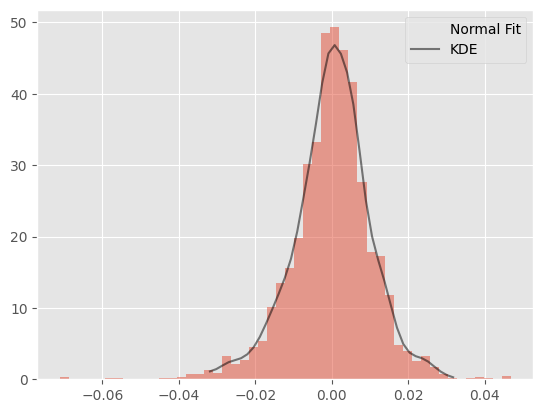

In [ ]:
#plt.hist(standardised_residuals, bins=100);plt.show()

errors_std = np.std(standardised_residuals)
errors_mu = np.mean(standardised_residuals)

kde = ss.gaussian_kde(standardised_residuals.dropna())

x = np.linspace(errors_mu - 3*errors_std, errors_mu + 3*errors_std, 40)


plt.hist(standardised_residuals, bins=50, density=True, alpha=0.5);
plt.plot(x, ss.t.pdf(x, errors_mu, errors_std), label= 'Normal Fit', alpha=0.);

plt.plot(x, kde(x), label='KDE', color='k', alpha=0.5);

plt.legend(); plt.show()


In [ ]:
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(measurements, dist=stats.distributions.t, plot=pylab)
pylab.show()

TypeError: _parse_args() missing 1 required positional argument: 'df'

In [ ]:
arma_model_fit.resid

Date
2012-11-05         NaN
2012-11-06    0.007076
2012-11-07   -0.022617
2012-11-08   -0.000834
2012-11-09    0.000214
                ...   
2022-10-31    0.001163
2022-11-01    0.009080
2022-11-02   -0.007872
2022-11-03   -0.008418
2022-11-04    0.025782
Length: 2510, dtype: float64

In [17]:
model_fit.predict()




AttributeError: 'ARCHModelResult' object has no attribute 'predict'

In [ ]:

residuals



model = arch_model(df['log_returns'].dropna(),
                 mean='Constant', 
                 vol='GARCH', 
                 p=1, q=1, rescale=True, dist='normal')

model_fit = model.fit()

Date
2012-11-05         NaN
2012-11-06    0.007076
2012-11-07   -0.022617
2012-11-08   -0.000834
2012-11-09    0.000214
                ...   
2022-10-31    0.001163
2022-11-01    0.009080
2022-11-02   -0.007872
2022-11-03   -0.008418
2022-11-04    0.025782
Length: 2510, dtype: float64

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 2510
Model:                 ARIMA(1, 0, 1)   Log Likelihood                7423.884
Date:                Fri, 11 Nov 2022   AIC                         -14839.768
Time:                        12:47:56   BIC                         -14816.456
Sample:                             0   HQIC                        -14831.307
                               - 2510                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.613      0.540      -0.000       0.001
ar.L1         -0.1665      0.431     -0.386      0.700      -1.012       0.679
ma.L1          0.1375      0.436      0.316      0.752      -0.716       0.991
sigma2         0.0002   1.84e-06     84.151      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             11025.26
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## copied from https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff



import pmdarima
import arch

# fit ARIMA on returns 
arima_model_fitted = pmdarima.auto_arima(returns)
p, d, q = arima_model.order
arima_residuals = arima_model.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_model.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et


NameError: name 'returns' is not defined